## Exponential Smoothing Example

In [1]:
# install and load necessary packages
!pip install seaborn
!pip install --upgrade --no-deps statsmodels

import pyspark
from datetime import datetime
import seaborn as sns
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

print('Python version ' + sys.version)
print('Spark version: ' + pyspark.__version__)

Requirement already up-to-date: statsmodels in /opt/app-root/lib/python3.6/site-packages (0.9.0)
Python version 3.6.3 (default, Mar 20 2018, 13:50:41) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-16)]
Spark version: 2.2.1


### Establish Connection to Spark Cluster

set configuration so that the Spark Cluster communicates with Ceph and reads a chunk of data.

In [2]:
import string 
import random

# Set the configuration
# random string for instance name
inst = ''.join(random.choices(string.ascii_uppercase + string.digits, k=4))
AppName = inst + ' - Ceph S3 Prometheus JSON Reader'
conf = pyspark.SparkConf().setAppName(AppName).setMaster('spark://spark-cluster.dh-prod-analytics-factory.svc:7077')
print("Application Name: ", AppName)

# specify number of nodes need (1-5)
conf.set("spark.cores.max", "2")

# specify Spark executor memory (default is 1gB)
conf.set("spark.executor.memory", "2g")

# Set the Spark cluster connection
sc = pyspark.SparkContext.getOrCreate(conf) 

# Set the Hadoop configurations to access Ceph S3
import os
(ceph_key, ceph_secret, ceph_host) = (os.getenv('DH_CEPH_KEY'), os.getenv('DH_CEPH_SECRET'), os.getenv('DH_CEPH_HOST'))
ceph_key = 'DTG5R3EEWN9JBYJZH0DF'
ceph_secret = 'pdcEGFERILlkRDGrCSxdIMaZVtNCOKvYP4Gf2b2x'
ceph_host = 'http://storage-016.infra.prod.upshift.eng.rdu2.redhat.com:8080'
sc._jsc.hadoopConfiguration().set("fs.s3a.access.key", ceph_key) 
sc._jsc.hadoopConfiguration().set("fs.s3a.secret.key", ceph_secret) 
sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", ceph_host) 

#Get the SQL context
sqlContext = pyspark.SQLContext(sc)

Application Name:  8H35 - Ceph S3 Prometheus JSON Reader


## Generate Counter Data
* l1 = bernoulli
* l2 = increasing by 1 from 1 to 100
* l3 = random reset to zero
* l4 = random increase and random resets

In [3]:
from datetime import date, datetime, timedelta

def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta

timestamps = []
for dt in perdelta(datetime(2018, 6, 27,4, 0), datetime(2018,6,27,4,1,40), timedelta(seconds=1)):
    timestamps.append(dt)
print("Number of Timestamps: ", len(timestamps))

Number of Timestamps:  100


In [4]:
import numpy as np
import copy

l1 = np.random.binomial(1, 0.5, 100).tolist()
l2 = np.arange(1,100).tolist()

l3 = []
num = 0

toggle = np.random.randint(1,40)
for i in range(1,100):
    num = num + 1
    if i % toggle == 0:
        toggle = np.random.randint(1,40)
        num = 0
    l3.append(num)
    
l4 = []
num = 0

toggle = np.random.randint(1,40)
for i in range(1,100):
    num = num + np.random.randint(1,6)
    if i % toggle == 0:
        toggle = np.random.randint(1,40)
        num = 0
    l4.append(num+1)

    
l = zip(l1,l2,l3,l4,timestamps)
schema = ["_1", "_2", "_3", "_4", "Timestamp"]

df_c = sqlContext.createDataFrame(l, schema)

In [5]:
df_c.show()

+---+---+---+---+-------------------+
| _1| _2| _3| _4|          Timestamp|
+---+---+---+---+-------------------+
|  0|  1|  1|  5|2018-06-27 04:00:00|
|  1|  2|  2|  6|2018-06-27 04:00:01|
|  1|  3|  3|  7|2018-06-27 04:00:02|
|  0|  4|  4| 12|2018-06-27 04:00:03|
|  0|  5|  5| 14|2018-06-27 04:00:04|
|  1|  6|  6| 15|2018-06-27 04:00:05|
|  0|  7|  7| 20|2018-06-27 04:00:06|
|  1|  8|  8| 22|2018-06-27 04:00:07|
|  0|  9|  9| 25|2018-06-27 04:00:08|
|  0| 10| 10| 29|2018-06-27 04:00:09|
|  0| 11| 11| 31|2018-06-27 04:00:10|
|  0| 12| 12| 34|2018-06-27 04:00:11|
|  0| 13| 13| 35|2018-06-27 04:00:12|
|  0| 14| 14| 36|2018-06-27 04:00:13|
|  1| 15| 15| 40|2018-06-27 04:00:14|
|  1| 16| 16| 43|2018-06-27 04:00:15|
|  1| 17| 17| 45|2018-06-27 04:00:16|
|  1| 18| 18| 50|2018-06-27 04:00:17|
|  0| 19| 19| 52|2018-06-27 04:00:18|
|  1| 20| 20| 53|2018-06-27 04:00:19|
+---+---+---+---+-------------------+
only showing top 20 rows



### Generate Data with Anomalies from Clean Data

In [6]:
l1_A = copy.copy(l1)
l1_A[24] = -1


l2_A = copy.copy(l2)
l2_A[94] = -1

l3_A = copy.copy(l3)
l3_A[36] = 32

l4_A = copy.copy(l4)
l4_A[57] = -10


l_A = zip(l1_A,l2_A,l3_A,l4_A,timestamps)

df_c_A = sqlContext.createDataFrame(l_A, schema)

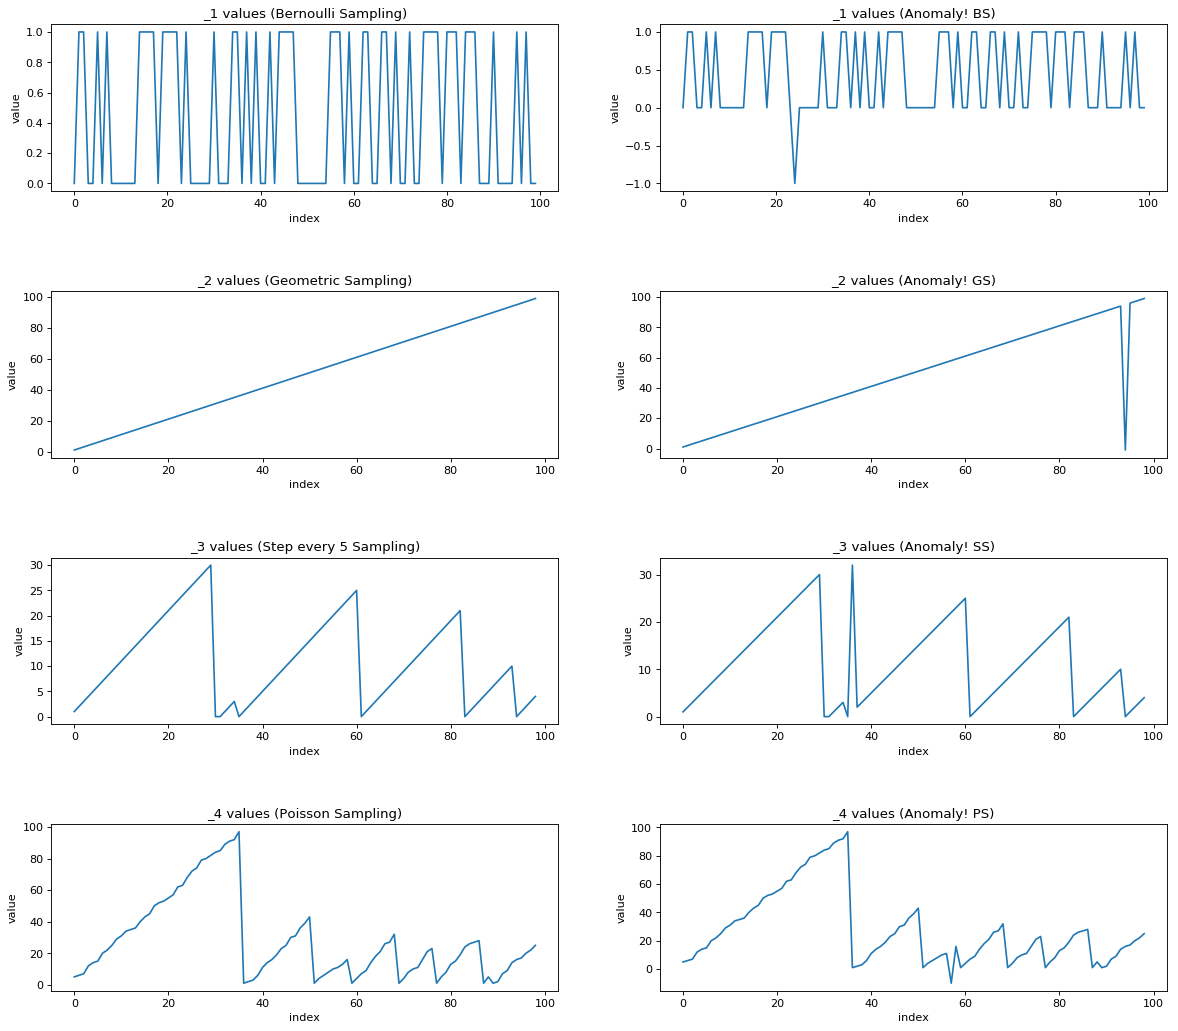

In [7]:
def plot_list(l, title):
    plt.plot(l)
    plt.xlabel("index")
    plt.ylabel("value")
    plt.title(title)

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=.6)
    
plt.subplot(421)
plot_list(l1,"_1 values (Bernoulli Sampling)")

plt.subplot(423)
plot_list(l2,"_2 values (Geometric Sampling)")

plt.subplot(425)
plot_list(l3,"_3 values (Step every 5 Sampling)")

plt.subplot(427)
plot_list(l4,"_4 values (Poisson Sampling)")



plt.subplot(422)
plot_list(l1_A,"_1 values (Anomaly! BS)")

plt.subplot(424)
plot_list(l2_A,"_2 values (Anomaly! GS)")

plt.subplot(426)
plot_list(l3_A,"_3 values (Anomaly! SS)")

plt.subplot(428)
plot_list(l4_A,"_4 values (Anomaly! PS)")


plt.show()




## Generate Gauge Data
* l1 = bernoulli
* l2 = geometric
* l3 = random integer from 1 to 25
* l4 = poisson
* l5 = seasonality example 1
* l6 = seasonality example 2

In [8]:
import numpy as np
import copy

l1 = np.random.binomial(1, 0.5, 100).tolist()
l2 = np.random.geometric(0.25, 100).tolist()
l3 = []
num = np.random.randint(1,25)

for i in range(1,100):
    if i % 5 == 0:
        num = np.random.randint(1,25)
    l3.append(num)
l4 = []
l4 = np.random.poisson(5,100).tolist()

l5 = []
val = 10
for i in range(1,100):
    change_val = 8# + int(np.random.randint(-1,1))
    if i%change_val == 0:
        val = -val
    val = val + float(np.random.normal(0,1,1))
    l5.append(val)
    
l6 = []
val = 10
for i in range(1,100):
    change_val = 8 + int(np.random.randint(-1,1))
    if i%change_val == 0:
        val = -val
    val = val + float(np.random.normal(0,1,1))
    l6.append(val)
    
l = zip(l1,l2,l3,l4,l5,l6)
df_g = sqlContext.createDataFrame(l, schema)

### Generate Data with Anomalies from Clean Data

In [9]:
l1_A = copy.copy(l1)
l1_A[24] = -1


l2_A = copy.copy(l2)
l2_A[94] = -1

l3_A = copy.copy(l3)
l3_A[36] = 32

l4_A = copy.copy(l4)
l4_A[57] = -10

l5_A = copy.copy(l5)
l5_A[36] = float(-12)
    
l6_A = copy.copy(l6)
l6_A[57] = float(-12)

l_A = zip(l1_A,l2_A,l3_A,l4_A,l5_A,l6_A, schema)

df_g_A = sqlContext.createDataFrame(l_A, schema)

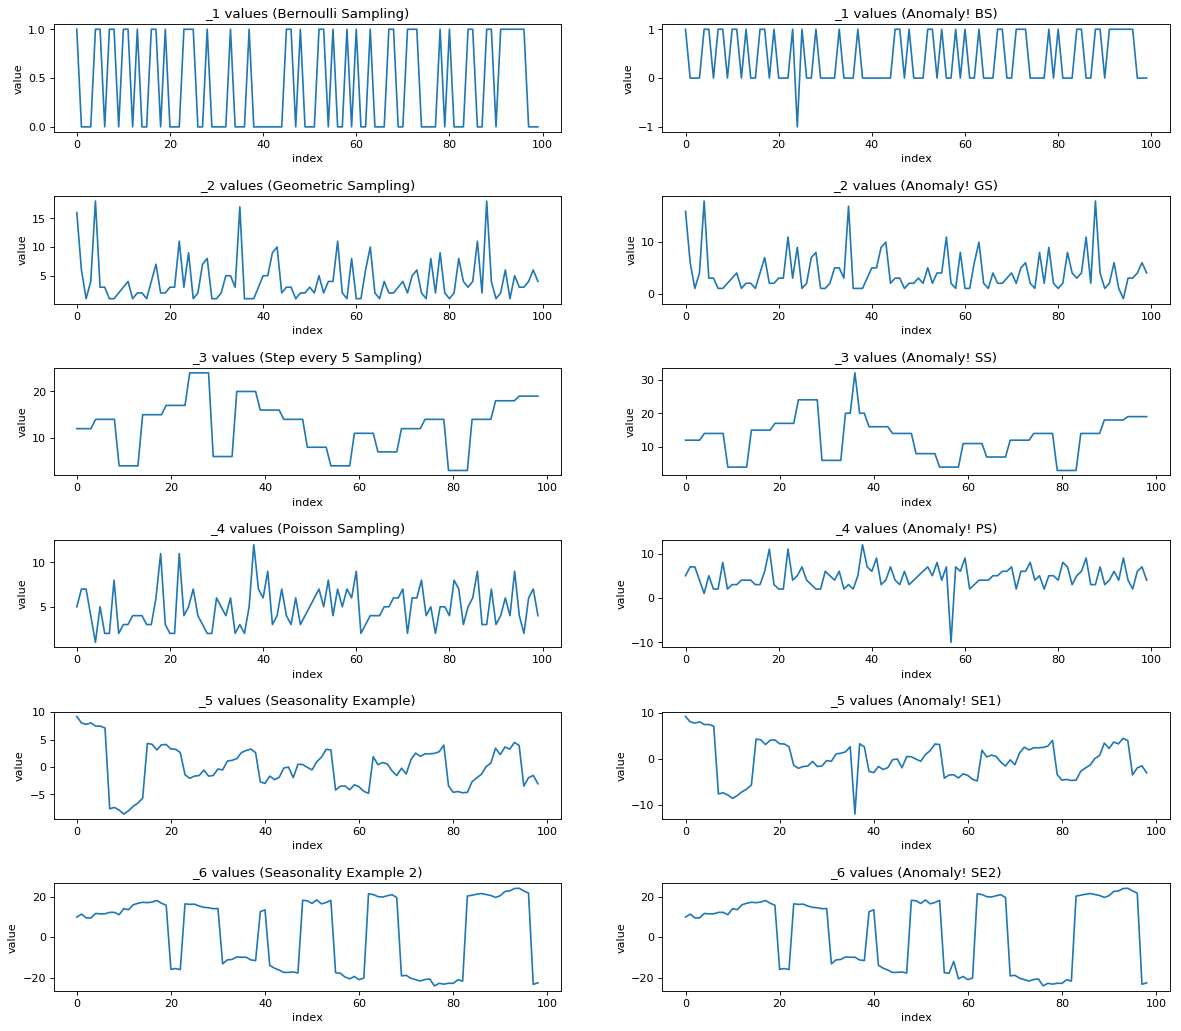

In [10]:
def plot_list(l, title):
    plt.plot(l)
    plt.xlabel("index")
    plt.ylabel("value")
    plt.title(title)

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=.6)
    
plt.subplot(621)
plot_list(l1,"_1 values (Bernoulli Sampling)")


plt.subplot(623)
plot_list(l2,"_2 values (Geometric Sampling)")

plt.subplot(625)
plot_list(l3,"_3 values (Step every 5 Sampling)")

plt.subplot(627)
plot_list(l4,"_4 values (Poisson Sampling)")

plt.subplot(629)
plot_list(l5,"_5 values (Seasonality Example)")

plt.subplot(6,2,11)
plot_list(l6,"_6 values (Seasonality Example 2)")



plt.subplot(622)
plot_list(l1_A,"_1 values (Anomaly! BS)")

plt.subplot(624)
plot_list(l2_A,"_2 values (Anomaly! GS)")

plt.subplot(626)
plot_list(l3_A,"_3 values (Anomaly! SS)")

plt.subplot(628)
plot_list(l4_A,"_4 values (Anomaly! PS)")

plt.subplot(6,2,10)
plot_list(l5_A,"_5 values (Anomaly! SE1)")

plt.subplot(6,2,12)
plot_list(l6_A,"_6 values (Anomaly! SE2)")

plt.show()




In [11]:
df_pd = df_c.toPandas()
df_pd = df_pd[["_4","Timestamp"]]
df_pd

,_4,Timestamp
0,5,2018-06-27 04:00:00
1,6,2018-06-27 04:00:01
2,7,2018-06-27 04:00:02
3,12,2018-06-27 04:00:03
4,14,2018-06-27 04:00:04
5,15,2018-06-27 04:00:05
6,20,2018-06-27 04:00:06
7,22,2018-06-27 04:00:07
8,25,2018-06-27 04:00:08
9,29,2018-06-27 04:00:09


In [12]:
df_pd.dtypes

_4                    int64
Timestamp    datetime64[ns]
dtype: object

In [13]:
sc.stop()

### Triple Exponential Smoothing (Holt Winters Method)

inspiration: https://github.com/statsmodels/statsmodels/blob/master/examples/notebooks/exponential_smoothing.ipynb

In [14]:
!pip install patsy
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import matplotlib.pyplot as plt
import pandas as pd

In [15]:
df_series = pd.Series(df_pd["_4"])
df_series.index = df_pd["Timestamp"]

In [16]:
df_series

Timestamp
2018-06-27 04:00:00     5
2018-06-27 04:00:01     6
2018-06-27 04:00:02     7
2018-06-27 04:00:03    12
2018-06-27 04:00:04    14
2018-06-27 04:00:05    15
2018-06-27 04:00:06    20
2018-06-27 04:00:07    22
2018-06-27 04:00:08    25
2018-06-27 04:00:09    29
2018-06-27 04:00:10    31
2018-06-27 04:00:11    34
2018-06-27 04:00:12    35
2018-06-27 04:00:13    36
2018-06-27 04:00:14    40
2018-06-27 04:00:15    43
2018-06-27 04:00:16    45
2018-06-27 04:00:17    50
2018-06-27 04:00:18    52
2018-06-27 04:00:19    53
2018-06-27 04:00:20    55
2018-06-27 04:00:21    57
2018-06-27 04:00:22    62
2018-06-27 04:00:23    63
2018-06-27 04:00:24    68
2018-06-27 04:00:25    72
2018-06-27 04:00:26    74
2018-06-27 04:00:27    79
2018-06-27 04:00:28    80
2018-06-27 04:00:29    82
                       ..
2018-06-27 04:01:09     1
2018-06-27 04:01:10     4
2018-06-27 04:01:11     8
2018-06-27 04:01:12    10
2018-06-27 04:01:13    11
2018-06-27 04:01:14    16
2018-06-27 04:01:15    21
20

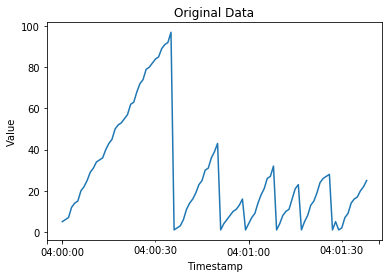

In [17]:
ax=df_series.plot(title="Original Data")
ax.set_ylabel("Value")
plt.show()

/opt/app-root/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  % freq, ValueWarning)


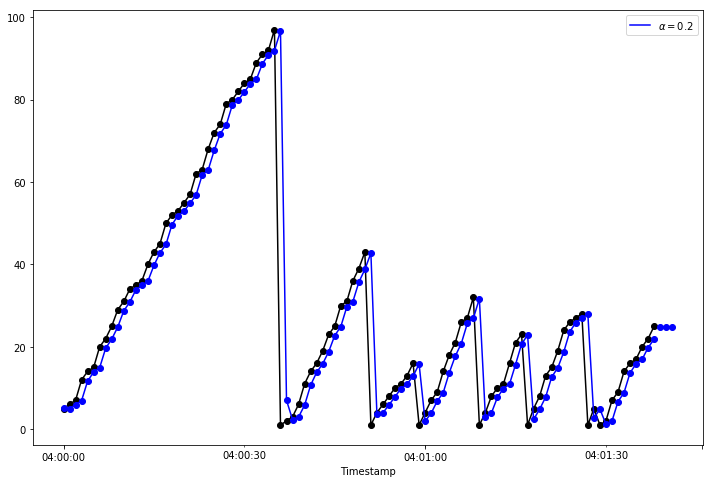

In [18]:
fit1  =  SimpleExpSmoothing(df_series).fit()
fcast1 = fit1.forecast(3).rename(r'$\alpha=0.2$')
ax = df_series.plot(marker='o', color='black', figsize=(12,8))
fcast1.plot(marker='o', ax=ax, color='blue', legend=True)
fit1.fittedvalues.plot(marker='o', ax=ax, color='blue')

In [19]:
fcast1

2018-06-27 04:01:39    24.803258
2018-06-27 04:01:40    24.803258
2018-06-27 04:01:41    24.803258
Freq: S, Name: $\alpha=0.2$, dtype: float64

/opt/app-root/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  % freq, ValueWarning)


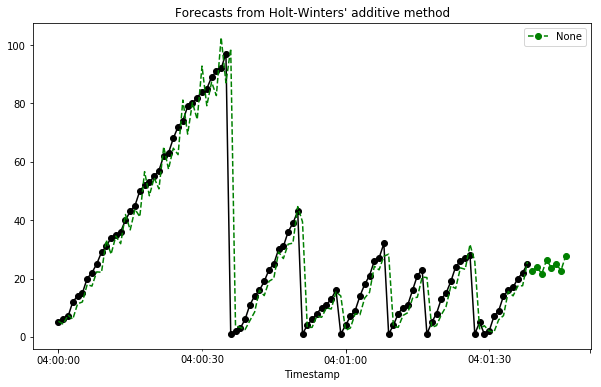

In [20]:
fit2 = ExponentialSmoothing(df_series, seasonal_periods=4, trend='add', seasonal='add').fit(use_boxcox=True)
results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_slope', 'damping_slope', 'smoothing_seasonal', 'initial_level', 'initial_slope']
results["Additive"] = [fit1.params[p] for p in params] + [fit1.sse]
ax = df_series.plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters' additive method" )
fit2.fittedvalues.plot(ax=ax, style='--', color='green')
fit2.forecast(8).plot(ax=ax, style='--', marker='o', color='green', legend=True)
plt.show()

/opt/app-root/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  % freq, ValueWarning)


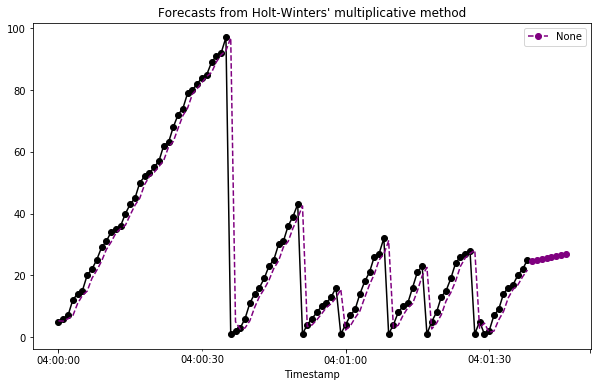

In [21]:
fit2 = ExponentialSmoothing(df_series, seasonal_periods=4, trend='add', seasonal='mult').fit(use_boxcox=True)
results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_slope', 'damping_slope', 'smoothing_seasonal', 'initial_level', 'initial_slope']
results["Additive"] = [fit1.params[p] for p in params] + [fit1.sse]
ax = df_series.plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters' multiplicative method" )
fit2.fittedvalues.plot(ax=ax, style='--', color='purple')
fit2.forecast(8).plot(ax=ax, style='--', marker='o', color='purple', legend=True)
plt.show()

In [22]:
from __future__ import print_function
import statsmodels.api as sm
from statsmodels.tsa.arima_process import arma_generate_sample
np.random.seed(12345)


In [37]:
arparams = np.array([.75, -.25])
maparams = np.array([.65, .35])

In [43]:
arparams = np.r_[1, -arparams]
maparams = np.r_[1, maparams]
nobs = 250
y = arma_generate_sample(arparams, maparams, nobs)

In [44]:
y

array([-7.61837213e-01, -1.85529132e+00, -3.86203993e+00, -4.26564607e+00,
       -2.17596392e+00, -1.20205615e+00, -2.07150185e+00, -2.86382752e+00,
       -5.74489916e-01,  1.69668616e+00,  9.74250942e-01, -1.82116306e+00,
       -2.37514827e+00,  2.70514858e-01,  1.25213868e+00,  2.74267459e-02,
       -7.61315314e-01,  3.27932317e-01,  2.15103920e+00,  2.62806218e+00,
        3.01145268e-01, -5.17787911e+00, -7.83576704e+00, -5.47337980e+00,
       -8.90028130e-02,  1.97060337e+00,  9.58525742e-01,  1.96640445e+00,
        3.67758109e+00,  2.97421347e+00,  1.00055627e+00, -9.88319981e-01,
       -2.19299942e+00, -1.51306665e+00,  1.18557167e-01,  1.36698450e+00,
        2.37552147e+00,  2.44652154e+00,  8.70742786e-01, -9.18529231e-01,
       -2.68762182e+00, -3.74069845e+00, -3.62250699e+00, -3.07690830e+00,
       -2.06870670e+00, -8.28551939e-01,  4.70019487e-01,  1.29251230e+00,
        1.45682777e+00,  1.56061730e-01, -3.42793744e-01, -1.41932312e-01,
       -9.36466482e-01,  

In [48]:
dates = sm.tsa.datetools.dates_from_range('1980m1', length=nobs)
y = df_series#pd.Series(y, index=dates)
arma_mod = sm.tsa.ARMA(y, order=(2,2))
arma_res = arma_mod.fit(trend='nc', disp=-1)

/opt/app-root/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  % freq, ValueWarning)


In [47]:
y

1980-01-31   -0.761837
1980-02-29   -1.855291
1980-03-31   -3.862040
1980-04-30   -4.265646
1980-05-31   -2.175964
1980-06-30   -1.202056
1980-07-31   -2.071502
1980-08-31   -2.863828
1980-09-30   -0.574490
1980-10-31    1.696686
1980-11-30    0.974251
1980-12-31   -1.821163
1981-01-31   -2.375148
1981-02-28    0.270515
1981-03-31    1.252139
1981-04-30    0.027427
1981-05-31   -0.761315
1981-06-30    0.327932
1981-07-31    2.151039
1981-08-31    2.628062
1981-09-30    0.301145
1981-10-31   -5.177879
1981-11-30   -7.835767
1981-12-31   -5.473380
1982-01-31   -0.089003
1982-02-28    1.970603
1982-03-31    0.958526
1982-04-30    1.966404
1982-05-31    3.677581
1982-06-30    2.974213
                ...   
1998-05-31   -3.465421
1998-06-30    0.306459
1998-07-31    2.966209
1998-08-31    2.595492
1998-09-30    1.037306
1998-10-31   -1.623450
1998-11-30   -1.453616
1998-12-31    0.662731
1999-01-31    2.783498
1999-02-28    2.921933
1999-03-31    0.266281
1999-04-30   -0.945077
1999-05-31 

In [49]:
print(arma_res.summary())

                              ARMA Model Results                              
Dep. Variable:                     _4   No. Observations:                   99
Model:                     ARMA(2, 2)   Log Likelihood                -386.533
Method:                       css-mle   S.D. of innovations             11.875
Date:                Fri, 06 Jul 2018   AIC                            783.065
Time:                        16:32:47   BIC                            796.041
Sample:                    06-27-2018   HQIC                           788.315
                         - 06-27-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1._4       0.6665      2.537      0.263      0.793      -4.306       5.639
ar.L2._4       0.2623      2.402      0.109      0.913      -4.445       4.970
ma.L1._4       0.2418      2.535      0.095      0.9

In [51]:
y.tail()

Timestamp
2018-06-27 04:01:34    16
2018-06-27 04:01:35    17
2018-06-27 04:01:36    20
2018-06-27 04:01:37    22
2018-06-27 04:01:38    25
Name: _4, dtype: int64

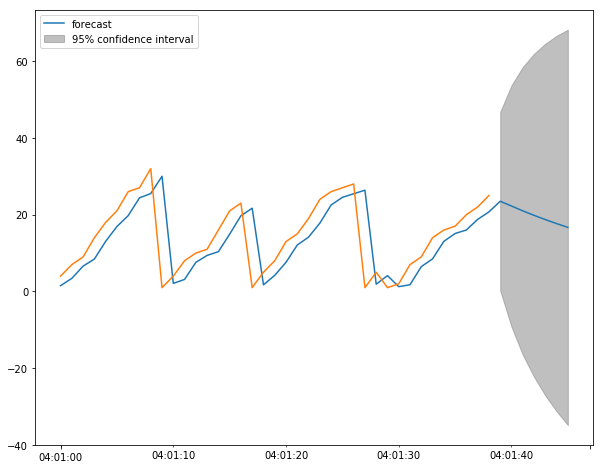

In [56]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,8))
fig = arma_res.plot_predict(start='2018-06-27 04:01:00', end='2018-06-27 04:01:45', ax=ax)
legend = ax.legend(loc='upper left')